In [1]:
import pandas as pd
import numpy as np
import random


# Creation

In [2]:

SEED = 42 # answer to everything
np.random.seed(SEED)
random.seed(SEED)

TRAIN_FRAC = 0.3
PUBLIC_LEADERBOARD_FRAC = 0.2
PRIVATE_LEADERBOARD_FRAC = 0.5
assert TRAIN_FRAC + PUBLIC_LEADERBOARD_FRAC + PRIVATE_LEADERBOARD_FRAC == 1, "Fractions must sum to 1"
N_TRAIN_SAMPLES = 10000
N_SAMPLES = int(N_TRAIN_SAMPLES // TRAIN_FRAC)
print(f"Total number of samples: {N_SAMPLES}")

PUBLIC_PRIVATE_SPLIT = 0.3 # Fraction of samples used for the public dataset
TEST_TRAIN_SPLIT = 0.2 # Fraction of samples used for the test set

ID_VARIABLE_NAME = "ID" # Name of the ID variable.
TARGET_VARIABLE_NAME = "y" # Name of the target variable.

INITIAL_NOISE = 0.1 # Previously was 0.3
FINAL_NOISE = 0.05 # Added to the final target
NAN_PROB = 0.1 # Probability of a value being NaN

DATA_DIR = "data"

Total number of samples: 33333


In [3]:
from sklearn.datasets import (
    make_moons, make_circles, make_blobs, make_classification, make_hastie_10_2,
    make_friedman1, make_friedman2, make_friedman3, make_regression
)
from typing import Callable

class ds:
    def __init__(self, weight: float, name: str, generator: Callable[[], tuple[np.ndarray, np.ndarray]]):
        self.weight: float = weight
        self.name: str = name

        self.raw_X: np.ndarray
        self.raw_y: np.ndarray
        self.raw_X, self.raw_y = generator()
        self.X: pd.DataFrame = pd.DataFrame(
            self.raw_X,
            columns=[
                f"{self.name}_{i+1}" for i in range(self.raw_X.shape[1])
            ]
        )
        self.y: pd.Series = pd.Series(self.raw_y, name="{self.name}_y")
    
    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return isinstance(other, ds) and self.name == other.name

# Make sure each has a unique name.
DATASETS: list[ds] = [
    ds(4, "moon",      lambda: make_moons(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(3, "circle",    lambda: make_circles(n_samples=N_SAMPLES, noise=INITIAL_NOISE, factor=0.6, random_state=SEED)),
    ds(2, "blob",      lambda: make_blobs(n_samples=N_SAMPLES, centers=3, n_features=2, random_state=SEED, return_centers=False)), # type: ignore # return_centers=False to avoid returning centers
    ds(2, "hastie",    lambda: make_hastie_10_2(n_samples=N_SAMPLES, random_state=SEED)),
    ds(2, "friedman1", lambda: make_friedman1(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman2", lambda: make_friedman2(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman3", lambda: make_friedman3(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(1, "class",     lambda: make_classification(n_samples=N_SAMPLES, n_features=5, n_informative=3, n_redundant=1, random_state=SEED)),
    ds(1, "reg",       lambda: make_regression(n_samples=N_SAMPLES, n_features=5, n_informative=3, noise=INITIAL_NOISE, random_state=SEED, coef=False)), # type: ignore # coef=False to avoid returning coefficients
]

In [4]:
df = pd.concat([d.X for d in DATASETS], axis=1)
normalized_weights = np.array([d.weight for d in DATASETS], dtype=np.float64) # dtype=np.float64 for division in the next line
normalized_weights /= normalized_weights.sum()

y_final = sum(DATASETS[i].y * normalized_weights[i] for i in range(len(DATASETS)))
y_final += np.random.normal(0, FINAL_NOISE, size= N_SAMPLES) # Some small, random noise to the final target
df[TARGET_VARIABLE_NAME] = y_final

id = pd.Series(np.arange(N_SAMPLES), name=ID_VARIABLE_NAME)
df[ID_VARIABLE_NAME] = id
# Making sure the ID column is the first column; makes the analysis prettier.
cols = [ID_VARIABLE_NAME] + [col for col in df.columns if col != ID_VARIABLE_NAME]
df = df[cols]

In [5]:
renaming = {
    ID_VARIABLE_NAME: 'LOCAL_IDENTIFIER',
    TARGET_VARIABLE_NAME: 'CORRUCYSTIC_DENSITY',

    'moon_1': 'v0rt3X',
    'moon_2': 'v1rt3X',
    'circle_1': 'r1Ng',
    'circle_2': 'r2Ng',
    'blob_1': 'b1oRb13',
    'blob_2': 'b2oRb13',
}

generic_cols = [col for col in df.columns if col not in renaming]

import string

def random_gibberish(mean_length: int = 4, std_length = 3) -> str:
    length = max(3, int(round(random.gauss(mean_length, std_length))))
    chars = string.ascii_letters + string.digits + string.punctuation
    return ''.join(random.choice(chars) for _ in range(length))

gibberish_mapping = {col: random_gibberish() for col in generic_cols}

final_mapping = {**renaming, **gibberish_mapping}

df.rename(columns=final_mapping, inplace=True)

# Testing

In [6]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
df.head()

,LOCAL_IDENTIFIER,v0rt3X,v1rt3X,r1Ng,r2Ng,b1oRb13,b2oRb13,JFCr,n](,dlBD#:d,...,w#n=,:zt,Vu(&a/P!,NEhE+kk~!i',qq[8),:2B(~_,z|NZ\@V,pFC,iRc.),CORRUCYSTIC_DENSITY
0,0,0.357426,-0.322764,0.001873,0.505807,-1.725027,9.043159,0.496714,-0.138264,0.647689,...,1.129102,-0.001454,-0.566153,1.284331,0.075630,-0.113823,-0.618728,-1.310186,-0.859761,130.691426
1,1,0.220267,1.015018,-0.860499,0.221977,-5.718679,-6.160025,-0.463418,-0.465730,0.241962,...,3.022866,-0.024995,-1.886118,1.635198,-0.608845,0.584451,-0.482178,1.346586,-1.267107,3.045957
2,2,0.320973,0.925499,-0.801558,0.512510,-7.815199,-8.534208,1.465649,-0.225776,0.067528,...,-1.479835,-1.485901,0.964668,-1.328036,0.029743,1.374305,0.245236,-1.373666,0.073546,7.446413
3,3,0.826164,0.221299,0.783882,0.384602,-6.570935,-6.766553,-0.601707,1.852278,-0.013497,...,-0.584960,0.426222,0.445678,0.531132,-0.160917,-0.722556,-0.413778,-0.625538,-0.017230,14.377987
4,4,1.342571,-0.559106,-0.465867,-0.602006,-2.226748,8.289901,0.738467,0.171368,-0.115648,...,-3.040667,-0.528820,1.935929,-1.595427,0.345430,-0.679394,-1.083462,-1.789171,-0.852532,46.084573


In [7]:
# Store ID column if it exists
if ID_VARIABLE_NAME in df.columns:
    id_col = df[ID_VARIABLE_NAME]
    df_no_id = df.drop(columns=[ID_VARIABLE_NAME])
else:
    id_col = None
    df_no_id = df.copy()

# Add NaNs to 10% of cells
n_cells = df_no_id.size
n_nan = int(n_cells * 0.10)

nan_indices = (
    np.random.choice(df_no_id.index, n_nan, replace=True),
    np.random.choice(df_no_id.columns, n_nan, replace=True)
)

for row, col in zip(*nan_indices):
    df_no_id.loc[row, col] = np.nan

# Reattach ID column if it existed
if id_col is not None:
    df = pd.concat([id_col, df_no_id], axis=1)
else:
    df = df_no_id

In [8]:
df.dropna(inplace=True)  # Drops any row with at least one NaN


Shape: (369, 46)

Missing values per column:
 LOCAL_IDENTIFIER       0
v0rt3X                 0
v1rt3X                 0
r1Ng                   0
r2Ng                   0
b1oRb13                0
b2oRb13                0
JFCr                   0
n](                    0
dlBD#:d                0
*z|@`(                 0
Jau                    0
`2RJtB                 0
lWmTS:H                0
f~6                    0
Wk)                    0
L=<                    0
y{if[D                 0
LkD                    0
6>UuVT                 0
A\I                    0
j:>                    0
v'~                    0
I>_*                   0
C^PhDeO                0
+|O                    0
B@"Y?                  0
F*'                    0
H-2-Z                  0
r$"                    0
lgot=u^2/iXW           0
G)b                    0
^}o                    0
I?R                    0
oL3                    0
}}H#                   0
w#n=                   0
:zt                    0
Vu(&

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


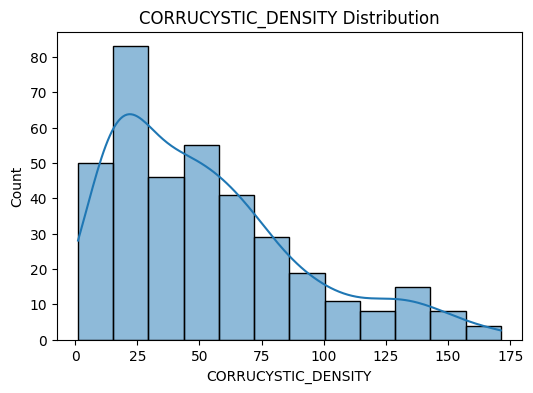

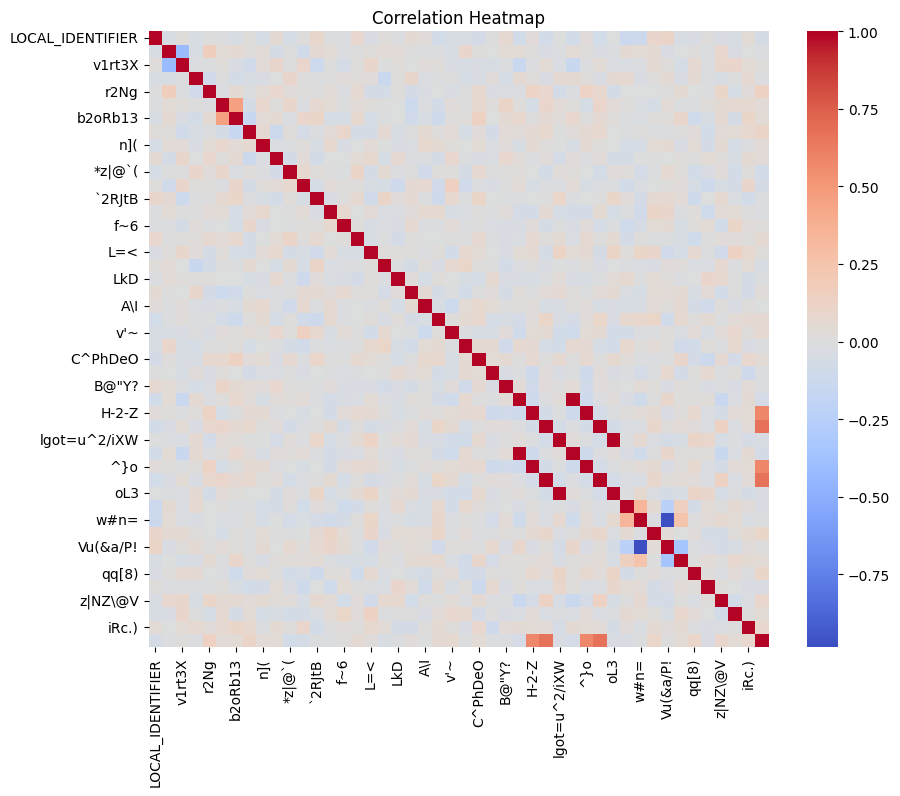


Top positive correlations with CORRUCYSTIC_DENSITY:
 I?R      0.667374
r$"      0.667374
H-2-Z    0.579666
^}o      0.579666
r2Ng     0.131542
Name: CORRUCYSTIC_DENSITY, dtype: float64

Top negative correlations with CORRUCYSTIC_DENSITY:
 Jau                -0.058322
LOCAL_IDENTIFIER   -0.061210
F*'                -0.067524
G)b                -0.067524
*z|@`(             -0.081515
Name: CORRUCYSTIC_DENSITY, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

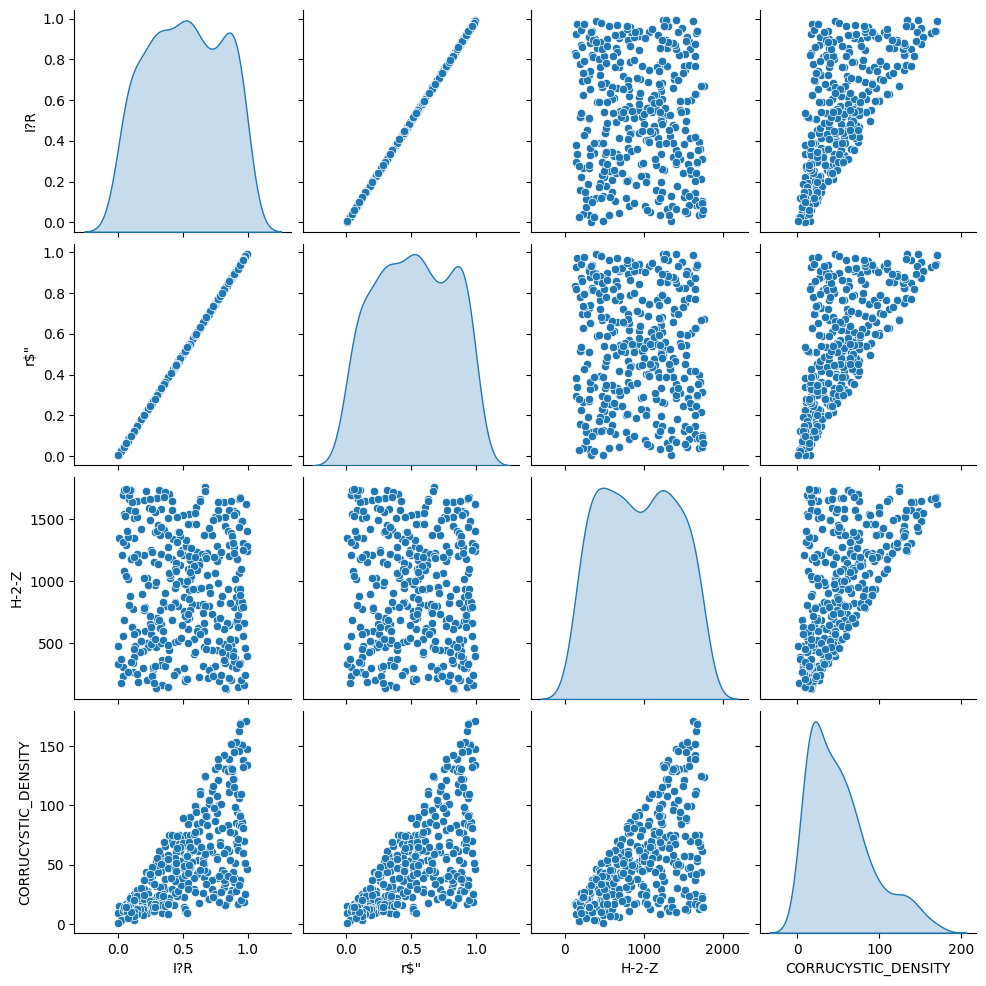

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already loaded your dataset into df
# df = pd.read_csv("/kaggle/input/...")

# ---------------------------
# Basic overview
# ---------------------------
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

# ---------------------------
# Distribution of CORRUCYSTIC_DENSITY
# ---------------------------
plt.figure(figsize=(6,4))
sns.histplot(df['CORRUCYSTIC_DENSITY'], kde=True)
plt.title("CORRUCYSTIC_DENSITY Distribution")
plt.show()

# ---------------------------
# Correlation Heatmap (numeric features only)
# ---------------------------
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap")
plt.show()

# ---------------------------
# Top correlations with CORRUCYSTIC_DENSITY
# ---------------------------
target_corr = corr['CORRUCYSTIC_DENSITY'].drop('CORRUCYSTIC_DENSITY').sort_values(ascending=False)
print("\nTop positive correlations with CORRUCYSTIC_DENSITY:\n", target_corr.head())
print("\nTop negative correlations with CORRUCYSTIC_DENSITY:\n", target_corr.tail())

# ---------------------------
# Pairplot for top 3 correlated features
# ---------------------------
top_feats = target_corr.abs().sort_values(ascending=False).head(3).index
sns.pairplot(df[[*top_feats, 'CORRUCYSTIC_DENSITY']], diag_kind='kde')
plt.show()

# ---------------------------
# Categorical feature distribution (top 2 by cardinality)
# ---------------------------
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols[:2]:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"{col} Distribution")
    plt.show()



In [10]:

# Calculate correlation matrix for numeric features
corr_matrix = df.corr(numeric_only=True)

# Unstack to turn into pairs
corr_pairs = corr_matrix.unstack()

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Take absolute values for sorting
corr_pairs = corr_pairs.abs().sort_values(ascending=False)

# Drop duplicate pairs (A,B) and (B,A)
corr_pairs = corr_pairs.groupby(lambda x: frozenset(x)).max()

# Get top 10
top_10 = corr_pairs.head(10)

# Display nicely
for pair, value in top_10.items():
    feat1, feat2 = tuple(pair)
    print(f"{feat1} ↔ {feat2} : correlation = {value:.2f}")

I?R ↔ r$" : correlation = 1.00
F*' ↔ Wk) : correlation = 0.02
y{if[D ↔ Vu(&a/P! : correlation = 0.02
f~6 ↔ +|O : correlation = 0.02
qq[8) ↔ :zt : correlation = 0.02
r1Ng ↔ f~6 : correlation = 0.02
dlBD#:d ↔ +|O : correlation = 0.02
v'~ ↔ w#n= : correlation = 0.02
Wk) ↔ z|NZ\@V : correlation = 0.02
Jau ↔ I?R : correlation = 0.02


In [11]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.drop('CORRUCYSTIC_DENSITY').tolist()
df.head()

,LOCAL_IDENTIFIER,v0rt3X,v1rt3X,r1Ng,r2Ng,b1oRb13,b2oRb13,JFCr,n](,dlBD#:d,...,w#n=,:zt,Vu(&a/P!,NEhE+kk~!i',qq[8),:2B(~_,z|NZ\@V,pFC,iRc.),CORRUCYSTIC_DENSITY
128,128.0,0.157538,0.206582,0.500164,0.521423,-7.237838,-6.692156,0.133541,-0.152470,0.708109,...,2.382888,1.023261,-1.174055,-0.232765,-0.508145,-1.441497,0.101286,-2.342731,1.669992,11.825397
307,307.0,-0.172336,0.775960,-0.888298,-0.599376,-6.569512,-4.879579,-1.269330,1.702515,0.202329,...,1.088386,0.383111,-0.486162,-1.211016,-0.646975,0.576152,1.497155,-0.740065,-0.904075,76.648735
526,526.0,-0.959792,0.367433,0.547617,-0.866286,-6.544003,-8.427070,1.252541,-0.779019,0.272421,...,-0.381879,-0.425184,0.310027,-0.707683,1.450760,-0.205845,-0.525262,-2.354651,-1.013264,61.539515
549,549.0,-1.135327,0.021968,0.854785,-0.166353,-7.723457,-5.927338,-0.411025,1.021623,-0.378760,...,0.739767,0.617601,-0.335473,1.135470,-1.042272,-0.518667,0.570421,-0.331431,0.853202,87.879934
797,797.0,-0.077685,0.840421,-0.796314,-0.532448,-3.256419,9.610295,1.597397,0.644690,-0.654770,...,0.454360,1.143582,-0.091080,-2.491106,-0.339453,0.414678,-1.003504,-1.212818,-0.109099,47.193172


In [12]:
X = df[numerical_cols] 
y = df['CORRUCYSTIC_DENSITY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     

In [13]:

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [14]:

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate predictions and MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred) 

# Calculate variance and ratio
variance = np.var(y_test)
print(f"Target variance: {variance:.2f}")
print(f"MSE: {mse:.2f}") 
print(f"MSE/Variance ratio: {mse/variance:.2f}")  # if ratio is <1 then better than simply predicting mean

Target variance: 1636.96
MSE: 285.90
MSE/Variance ratio: 0.17


# Csv creation

In [15]:


# Store ID column if it exists
if ID_VARIABLE_NAME in df.columns:
    id_col = df[ID_VARIABLE_NAME]
    df_no_id = df.drop(columns=[ID_VARIABLE_NAME])
else:
    id_col = None
    df_no_id = df.copy()

# Add NaNs to 10% of cells
n_cells = df_no_id.size
n_nan = int(n_cells * 0.10)

nan_indices = (
    np.random.choice(df_no_id.index, n_nan, replace=True),
    np.random.choice(df_no_id.columns, n_nan, replace=True)
)

for row, col in zip(*nan_indices):
    df_no_id.loc[row, col] = np.nan

# Reattach ID column if it existed
if id_col is not None:
    df = pd.concat([id_col, df_no_id], axis=1)
else:
    df = df_no_id
df.head()

,LOCAL_IDENTIFIER,v0rt3X,v1rt3X,r1Ng,r2Ng,b1oRb13,b2oRb13,JFCr,n](,dlBD#:d,...,w#n=,:zt,Vu(&a/P!,NEhE+kk~!i',qq[8),:2B(~_,z|NZ\@V,pFC,iRc.),CORRUCYSTIC_DENSITY
128,128.0,0.157538,0.206582,0.500164,NaN,-7.237838,-6.692156,0.133541,-0.152470,0.708109,...,2.382888,1.023261,-1.174055,NaN,-0.508145,NaN,0.101286,NaN,1.669992,11.825397
307,307.0,-0.172336,0.775960,-0.888298,-0.599376,-6.569512,-4.879579,-1.269330,1.702515,0.202329,...,1.088386,0.383111,NaN,-1.211016,-0.646975,0.576152,1.497155,-0.740065,NaN,76.648735
526,526.0,-0.959792,0.367433,NaN,-0.866286,-6.544003,-8.427070,1.252541,-0.779019,0.272421,...,NaN,-0.425184,0.310027,-0.707683,1.450760,-0.205845,-0.525262,-2.354651,-1.013264,61.539515
549,549.0,-1.135327,0.021968,0.854785,NaN,-7.723457,-5.927338,-0.411025,1.021623,-0.378760,...,0.739767,0.617601,-0.335473,1.135470,-1.042272,-0.518667,0.570421,-0.331431,0.853202,87.879934
797,NaN,-0.077685,0.840421,-0.796314,-0.532448,-3.256419,9.610295,NaN,0.644690,-0.654770,...,0.454360,1.143582,-0.091080,-2.491106,-0.339453,NaN,-1.003504,-1.212818,-0.109099,47.193172


In [16]:
# Shuffle columns, keeping the target column at the end and ID at the beginning
cols = df.columns.tolist()
df = df[[cols[0]] + np.random.permutation(cols[1:-1]).tolist() + [cols[-1]]]

In [17]:
N_PUBLIC_SAMPLES = int(N_SAMPLES * PUBLIC_LEADERBOARD_FRAC)
train = df.iloc[:N_TRAIN_SAMPLES]
public = df.iloc[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES + N_PUBLIC_SAMPLES]
private = df.iloc[N_TRAIN_SAMPLES + N_PUBLIC_SAMPLES:]

In [18]:
from datetime import datetime

# In Kaggle, all outputs should be stored in /kaggle/working/
DATA_DIR = "/kaggle/working"

timestamp = datetime.now().strftime("%d_%H-%M-%S")

train.to_csv(f"{DATA_DIR}/{timestamp}_train.csv", index=False)
public.to_csv(f"{DATA_DIR}/{timestamp}_public.csv", index=False)
private.to_csv(f"{DATA_DIR}/{timestamp}_private.csv", index=False)

print("Files saved to:", DATA_DIR)


Files saved to: /kaggle/working
